To do
  * Build proper bands highfield
  * Build proper bands lowfield
  * What to do with tts?

In [1]:
# %run '../definitions.ipynb'

In [1]:
%run 'psd_mc_functions.ipynb'

Reading XAMS data from pickles...
Read data in 3.09 seconds


In [9]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [2]:
X = pickle.load(open('X.pickle', 'rb'))

## Band conversion and fit values

In [70]:
def convert_s1_to_E(cs1, field='high'):
    '''
    Given the S1, get the energy in ER and NR band center
    '''
    if field == 'high':
        bands = pickle.load(open('OLD_pickles/highfield_bands_1.0_sigmas_er_nr.pickle', 'rb'))
    g1, g2 = pickle.load(open('../light_yield/data/doke_sel2.pickle', 'rb'))
    
    cs1_list = bands[0]
    er_mean = bands[1][1]
    nr_mean = bands[2][1]
    er_cs2 = np.interp(cs1, cs1_list, er_mean)
    nr_cs2 = np.interp(cs1, cs1_list, nr_mean)
    er_e = 13.7e-3 * ((cs1 / g1) + (er_cs2 / g2))
    nr_e = 13.7e-3 * ((cs1 / g1) + (nr_cs2 / g2))
    
    return er_e, nr_e

In [ ]:
def convert_E_to_cs1(E, field='high'):
    '''
    Given the S1, get the energy in ER and NR band center
    '''
    if field == 'high':
        bands = pickle.load(open('OLD_pickles/highfield_bands_1.0_sigmas_er_nr.pickle', 'rb'))
    g1, g2 = pickle.load(open('../light_yield/data/doke_sel2.pickle', 'rb'))
    
    cs1_list = bands[0]
    er_mean = bands[1][1]
    nr_mean = bands[2][1]
    er_e = 13.7e-3 * ((cs1_list / g1) + (er_cs2 / g2))
    
    er_cs2 = np.interp(cs1, cs1_list, er_mean)
    nr_cs2 = np.interp(cs1, cs1_list, nr_mean)
    er_e = 13.7e-3 * ((cs1 / g1) + (er_cs2 / g2))
    nr_e = 13.7e-3 * ((cs1 / g1) + (nr_cs2 / g2))
    
    return er_e, nr_e

In [ ]:
def convert_s1_to_E(cs1, field='high'):
    '''
    Given the S1, get the energy in ER and NR band center
    '''
    if field == 'high':
        bands = pickle.load(open('OLD_pickles/highfield_bands_1.0_sigmas_er_nr.pickle', 'rb'))
    g1, g2 = pickle.load(open('../light_yield/data/doke_sel2.pickle', 'rb'))
    
    cs1_list = bands[0]
    er_mean = bands[1][1]
    nr_mean = bands[2][1]
    er_cs2 = np.interp(cs1, cs1_list, er_mean)
    nr_cs2 = np.interp(cs1, cs1_list, nr_mean)
    er_e = 13.7e-3 * ((cs1 / g1) + (er_cs2 / g2))
    nr_e = 13.7e-3 * ((cs1 / g1) + (nr_cs2 / g2))
    
    return er_e, nr_e

In [49]:
def get_fit_values(E, band, X,field='high'):
    '''
    Extract the fit values for specific energies
    '''
    if field == 'high':
        if band == 'er':
            x = X[0]
        elif band == 'nr':
            x = X[1]
    es = x['e']
    ret = []
    for key in ['t3', 'fs', 't1', 'tts']:
        ret.append(np.interp(E, es, x[key]))
    return np.array(ret)

## Simulation

In [50]:
def simulate_photon_times(n_photons, t1, t3, fs, tts):
    times = np.zeros(n_photons)
    n_singlets = np.random.binomial(n=n_photons, p=fs)
    times += np.concatenate([
        np.random.exponential(t1, n_singlets),
        np.random.exponential(t3, n_photons - n_singlets)
    ])
    np.random.shuffle(times)
    times += np.random.normal(0, tts, size=n_photons)
    return times
    

In [51]:
def build_likelihood_function(n_photons, t1, t3, fs, tts, hist_range, hist_bins, 
                              offset = None, plot=False, ):
    if offset is None:
        offset = 1 / n_photons
    times = simulate_photon_times(n_photons, t1, t3, fs, tts)
    vals, edges  = np.histogram(times, range = hist_range, bins = hist_bins, normed=True)
    vals = np.max([vals, np.ones(len(vals)) * offset], axis=0)
    centers = 0.5 * (edges[:-1] + edges[1:])
    def f(x):
        return np.interp(x, centers, vals)
    def negloglikelihood(x):
        return np.interp(x, centers, -np.log(vals))
    
    if plot:
        x_plot = centers
        plt.hist(times, range = hist_range, bins = hist_bins, normed=True, histtype = 'step')
        plt.plot(centers, f(centers))
        plt.yscale('log')
    return negloglikelihood

In [52]:
def simulate_s1_times(n_photons, t1, t3, fs, tts, photons_per_s1):
    times = simulate_photon_times(n_photons, t1, t3, fs, tts)
    n_s1s = int(np.floor(n_photons / photons_per_s1))
    times = times[:(n_s1s * photons_per_s1)]
    s1_times = np.split(times, n_s1s)
    return np.array(s1_times)

In [53]:
from tqdm import tqdm
def max_likelihood(s1_times, f):
    shifts = []
    likes = []
    for s1 in tqdm(s1_times):
        optres = scipy.optimize.minimize(lambda x: np.sum(f(s1 + x)), 0.)
        shifts.append(optres.x[0])
        likes.append(optres.fun)
    return likes, shifts

In [140]:
def likelihood_ratio(s1s, f_er, f_nr):
    er_likelihood = max_likelihood(s1s, f_er)
    nr_likelihood = max_likelihood(s1s, f_nr)
    # LR = np.array(nr_likelihood[0]) / np.array(er_likelihood[0])
    LR = np.array(nr_likelihood[0]) - np.array(er_likelihood[0])
    return LR

## Build likelihoods

In [106]:
nr_params = dict(
    fs = 0.4, 
    t3 = 24,
    t1 = 2.,
    tts = 0.1#1.75,
)

er_params = dict(
    fs = 0.18,
    t3 = 24,
    t1 = 2.,
    tts = 0.1 # 1.75,
)

In [107]:
f_er = build_likelihood_function(int(1e7), hist_range = (-50, 250), hist_bins = 1000, **er_params)
f_nr = build_likelihood_function(int(1e7), hist_range = (-50, 250), hist_bins = 1000, **nr_params)


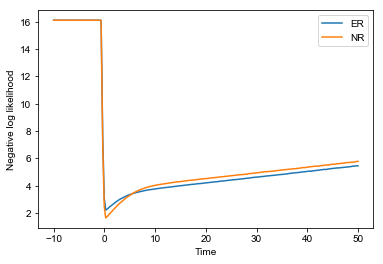

In [108]:
t = np.linspace(-10, 50, 1000)
plt.plot(t, f_er(t), label='ER')
plt.plot(t, f_nr(t), label='NR')
plt.xlabel('Time')
plt.ylabel('Negative log likelihood')
plt.legend()

## Build ER and NR s1 samples

In [109]:
photons_per_s1 = 30 # photons
n_s1s = 500
n_ph = n_s1s * photons_per_s1

In [110]:
s1s_er = simulate_s1_times(n_ph, photons_per_s1 = photons_per_s1, **er_params)
s1s_nr = simulate_s1_times(n_ph, photons_per_s1 = photons_per_s1, **nr_params)

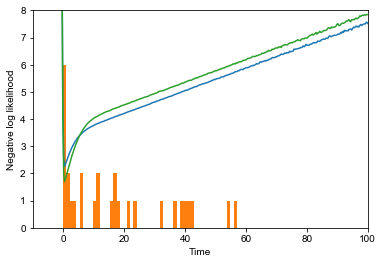

In [111]:
t = np.linspace(-50, 250, 1000)
plt.plot(t, f_er(t), label='ER')
plt.hist(s1s_er[0], bins=100, range=(-10, 100), label='ER sample')
plt.plot(t, f_nr(t), label='NR')
plt.xlabel('Time')
plt.ylabel('Negative log likelihood')
plt.xlim(-10, 100)
plt.ylim(0, 8)
plt.show()

In [141]:
nr_lr = likelihood_ratio(s1s_nr, f_er, f_nr)
er_lr = likelihood_ratio(s1s_er, f_er, f_nr)

100%|██████████| 500/500 [00:07<00:00, 64.30it/s]


(array([   4.,   14.,   29.,   61.,  102.,  112.,   88.,   54.,   26.,   10.]),
 array([-4.06919592, -3.03925337, -2.00931082, -0.97936826,  0.05057429,
         1.08051684,  2.11045939,  3.14040194,  4.1703445 ,  5.20028705,
         6.2302296 ]),
 <a list of 10 Patch objects>)

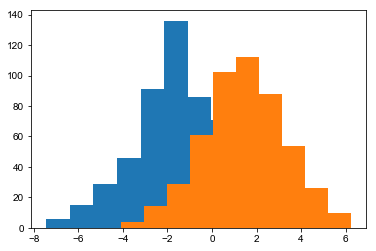

In [143]:
plt.hist(nr_lr)
plt.hist(er_lr)


In [114]:
off = 0.1

scan_values = np.linspace(1 - off, 1 + off, 200)
nr_acc = np.array([np.sum(nr_lr >= discval) / len(nr_lr) for discval in scan_values])
er_acc = np.array([np.sum(er_lr >= discval) / len(er_lr) for discval in scan_values])

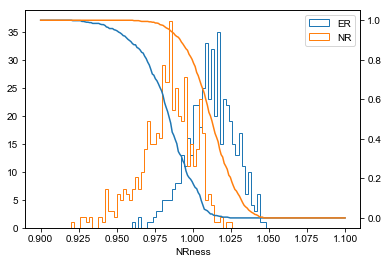

In [115]:
plt.hist(er_lr, 
         bins=100, histtype='step', label='ER', range=(1 - off, 1+ off))
plt.hist(nr_lr,
         bins=100, histtype='step', label='NR', range=(1 - off, 1+ off))
plt.xlabel('NRness')
plt.legend()
plt.twinx()
plt.plot(scan_values, nr_acc)
plt.plot(scan_values, er_acc)

plt.show()

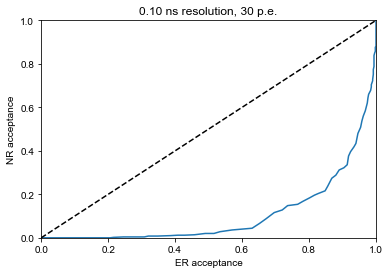

In [116]:
plt.plot(er_acc, nr_acc)
plt.plot([0,1], [0,1],ls='--', color='black')
plt.xlabel('ER acceptance')
plt.ylabel('NR acceptance')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("%.2f ns resolution, %d p.e." % (er_params['tts'], photons_per_s1))
plt.show()

## All combined

In [63]:
cs1 = 20

In [131]:
def get_er_acc(cs1, n_s1s = 500, field = 'high', plot=True):
    E_er, E_nr = convert_s1_to_E(cs1, field=field)
    print('Working on cs1 %f, Eer = %.1f keV, Enr = %.1f keV...' % (cs1, E_er, E_nr))
    params_er = get_fit_values(E_er, 'er', X, field=field)
    params_nr = get_fit_values(E_nr, 'nr', X, field=field)
    p_er = dict(t3 = params_er[0], fs = params_er[1], t1 = params_er[2], tts = params_er[3])
    p_nr = dict(t3 = params_nr[0], fs = params_nr[1], t1 = params_nr[2], tts = params_nr[3])
    print('ER: ' , p_er)
    print('NR: ' , p_nr)
    
    print('Building likelihoods...')
    f_er = build_likelihood_function(int(1e7), hist_range = (-50, 250), hist_bins = 1000, **p_er)
    f_nr = build_likelihood_function(int(1e7), hist_range = (-50, 250), hist_bins = 1000, **p_nr)
    
    n_ph = n_s1s * cs1
    print('Building samples...')
    s1s_er = simulate_s1_times(n_ph, photons_per_s1 = cs1, **p_er)
    s1s_nr = simulate_s1_times(n_ph, photons_per_s1 = cs1, **p_nr)
    
    print('Building likelihood ratios...')
    er_lr = likelihood_ratio(s1s_er, f_er, f_nr)
    nr_lr = likelihood_ratio(s1s_nr, f_er, f_nr)

    
    # Now get the 50% nr acc 
    cutoff = np.mean(nr_lr)
    leaks = np.sum(er_lr >= cutoff)
    leak_frac = leaks / len(er_lr)
    
    print('Cutoff at %f' % cutoff)
    print('Passing %d of %d ER events, %.1f %%' % (leaks, len(er_lr), 100 * leak_frac))
    
    if plot:
        ran = 3 * np.std(er_lr)
        for lr, _l in zip([er_lr, nr_lr], ['ER', 'NR']):
            plt.hist(lr, bins=100, histtype='step', range=(1-ran, 1+ran), label=_l)
        plt.axvline(cutoff, label='cutoff', ls='--', color='red', lw=2)
        plt.legend()
        plt.show()
    

    
    return leak_frac

Working on cs1 50.000000, Eer = 21.2 keV, Enr = 14.1 keV...
ER:  {'t1': 3.3427784718085962, 'fs': 0.17407221528191405, 't3': 25.14819461795215, 'tts': 1.4259026910239254}
NR:  {'t1': 2.75, 'fs': 0.245, 't3': 22.0, 'tts': 1.25}
Building likelihoods...


  0%|          | 6/5000 [00:00<01:25, 58.10it/s]

Building samples...
Building likelihood ratios...


 82%|████████▏ | 4121/5000 [00:55<00:11, 76.21it/s]/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
 27%|██▋       | 1361/5000 [00:18<00:51, 70.64it/s]/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
 39%|███▉      | 1968/5000 [00:26<00:39, 76.33it/s]/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
100%|██████████| 5000/5000 [01:07<00:00, 74.39it/s]


Cutoff at 0.994486
Passing 4538 of 5000 ER events, 90.8 %


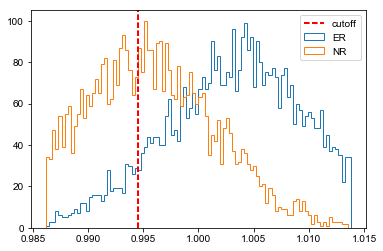

In [105]:
er_lr, nr_lr = get_er_acc(cs1 = 50, n_s1s = 5000)

In [97]:
np.median(nr_lr)

1.0199339595946724

### Build for various cs1

In [125]:
cs1_list = [10, 20, 30, 40, 50, 60]

In [126]:
for cs1 in cs1_list:
    print(convert_s1_to_E(cs1))

(6.9610550732109475, 4.0112840472132616)
(10.406302184743979, 6.8627583952638869)
(13.86839724136045, 9.508188707455755)
(17.412994262765313, 11.894725102708794)
(21.154691751010038, 14.064720687577864)
(24.962724148736061, 16.100159913186342)


In [127]:
import pandas as pd

Working on cs1 10.000000, Eer = 7.0 keV, Enr = 4.0 keV...
ER:  {'t1': 1.5644033964134068, 'fs': 0.18816625055781008, 't3': 23.527284075696087, 'tts': 1.6992386414346372}
NR:  {'t1': 0.69265861334347112, 'fs': 0.22807341386656529, 't3': 21.5, 'tts': 1.7018353466641323}
Building likelihoods...


  6%|▌         | 6/100 [00:00<00:01, 52.91it/s]

Building samples...
Building likelihood ratios...


100%|██████████| 100/100 [00:01<00:00, 79.87it/s]


Cutoff at 0.995244
Passing 62 of 100 ER events, 62.0 %


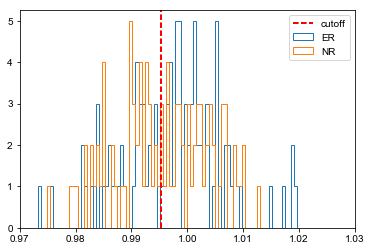

Working on cs1 20.000000, Eer = 10.4 keV, Enr = 6.9 keV...
ER:  {'t1': 2.128300776138389, 'fs': 0.17999999999999999, 't3': 24.222875970172986, 'tts': 1.5777124029827014}
NR:  {'t1': 1.3992077930880122, 'fs': 0.22100792206911987, 't3': 21.5, 'tts': 1.5251980517279971}
Building likelihoods...


  8%|▊         | 8/100 [00:00<00:01, 76.72it/s]

Building samples...
Building likelihood ratios...


100%|██████████| 100/100 [00:01<00:00, 74.31it/s]


Cutoff at 0.996024
Passing 73 of 100 ER events, 73.0 %


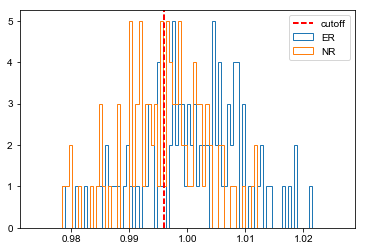

Working on cs1 30.000000, Eer = 13.9 keV, Enr = 9.5 keV...
ER:  {'t1': 2.5873878396075911, 'fs': 0.17999999999999999, 't3': 24.79673479950949, 'tts': 1.520326520049051}
NR:  {'t1': 2.07424741816908, 'fs': 0.2314849483633816, 't3': 21.72969896726763, 'tts': 1.3851505163661839}
Building likelihoods...


  8%|▊         | 8/100 [00:00<00:01, 73.95it/s]

Building samples...
Building likelihood ratios...


100%|██████████| 100/100 [00:01<00:00, 75.85it/s]


Cutoff at 0.996546
Passing 80 of 100 ER events, 80.0 %


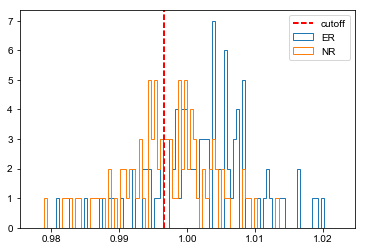

Working on cs1 40.000000, Eer = 17.4 keV, Enr = 11.9 keV...
ER:  {'t1': 2.9767718776959198, 'fs': 0.1777322812230408, 't3': 25.056692969423981, 'tts': 1.4716535152880101}
NR:  {'t1': 2.6864284117444122, 'fs': 0.24372856823488825, 't3': 21.974571364697766, 'tts': 1.2627143176511175}
Building likelihoods...


  9%|▉         | 9/100 [00:00<00:01, 81.80it/s]

Building samples...
Building likelihood ratios...


100%|██████████| 100/100 [00:01<00:00, 70.61it/s]


Cutoff at 0.994168
Passing 84 of 100 ER events, 84.0 %


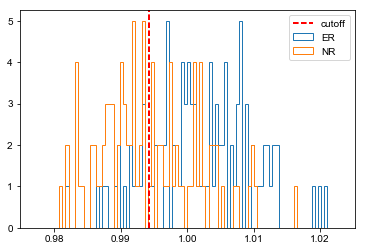

Working on cs1 50.000000, Eer = 21.2 keV, Enr = 14.1 keV...
ER:  {'t1': 3.3427784718085962, 'fs': 0.17407221528191405, 't3': 25.14819461795215, 'tts': 1.4259026910239254}
NR:  {'t1': 2.75, 'fs': 0.245, 't3': 22.0, 'tts': 1.25}
Building likelihoods...


 10%|█         | 10/100 [00:00<00:00, 92.77it/s]

Building samples...
Building likelihood ratios...


100%|██████████| 100/100 [00:01<00:00, 70.91it/s]


Cutoff at 0.993804
Passing 93 of 100 ER events, 93.0 %


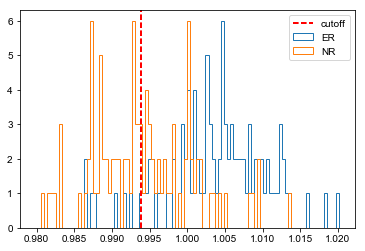

Working on cs1 60.000000, Eer = 25.0 keV, Enr = 16.1 keV...
ER:  {'t1': 3.7152738358889943, 'fs': 0.17034726164111008, 't3': 25.241318458972248, 'tts': 1.3793407705138756}
NR:  {'t1': 2.75, 'fs': 0.245, 't3': 22.0, 'tts': 1.25}
Building likelihoods...


  7%|▋         | 7/100 [00:00<00:01, 64.94it/s]

Building samples...
Building likelihood ratios...


100%|██████████| 100/100 [00:01<00:00, 72.60it/s]


Cutoff at 0.993891
Passing 96 of 100 ER events, 96.0 %


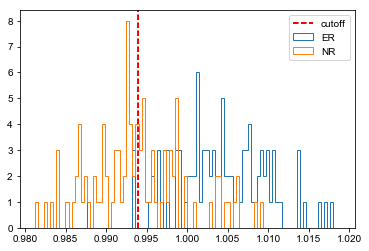

In [132]:
df = []
for cs1 in cs1_list:
    el = {}
    el['cs1'] = cs1
    el['e_er'], el['e_nr'] = convert_s1_to_E(cs1)
    el['leak'] = get_er_acc(cs1, n_s1s = 100, plot=False)
    df.append(el)
    
    
df = pd.DataFrame(df)

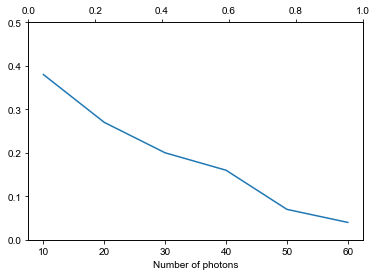

In [139]:
plt.plot(df['cs1'], 1 - df['leak'])
# plt.xlim(0, 25)
plt.ylim(0, 0.5)
plt.xlabel('Number of photons')
# plt.xlabel('Energy in ER band')
plt.twiny()

In [ ]:
convert_s1_to_E